# Indoor Care Chatbot (YOLO + ChatGPT)

### Load the previously prepared OpenVINO optimized YOLOv8 model

In [1]:
from openvino.runtime import Core
core = Core()
# Load the pre optimized model
yolov8n_with_preprocess_model = core.read_model('models/yolov8n_openvino_int8_model/yolov8n_with_preprocess.xml',)

import json
# Load the label map
with open('models/yolov8n_labels.json', 'r') as f:
    label_map = json.load(f)
    label_map = {int(k): v for k, v in label_map.items()}

### Setup the live player for inference

In [2]:
import collections
from IPython import display
import cv2
import numpy as np
import time
from utils import VideoPlayer, detect_without_preprocess, draw_results

# Run the object detection
def run_object_detection(source=0, flip=False, skip_first_frames=0, model="None", device="None"):
    player = None
    # if device != "CPU":
    #     model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect_without_preprocess(input_image, compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes, distance_array = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Display distance array information
            # distance_text = "\n".join([f"{pair[0]}-{pair[1]}: {pair[2]:.1f}" for pair in distance_array])
            # cv2.putText(
            #     img=frame,
            #     text=distance_text,
            #     org=(20, 60),
            #     fontFace=cv2.FONT_HERSHEY_COMPLEX,
            #     fontScale=f_width / 1000,
            #     color=(0, 255, 0),
            #     thickness=1,
            #     lineType=cv2.LINE_AA,
            # )

            # Encode numpy array to jpg.
            _, encoded_img = cv2.imencode(
                ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
            )
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
    # any different error
    except RuntimeError as e:
        print(e)
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()


### Run the inference

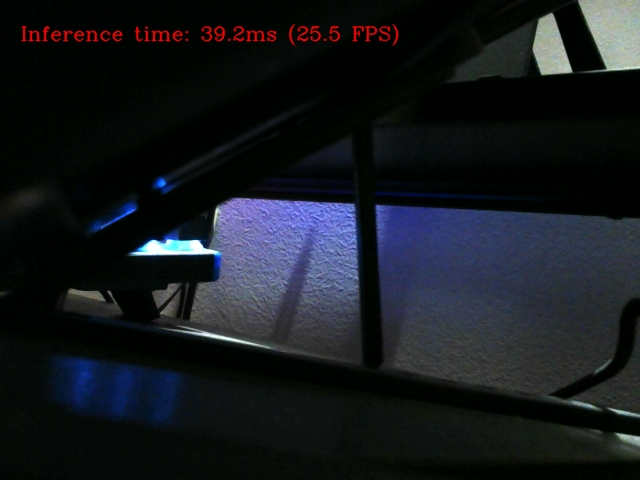

Interrupted


In [3]:
# Start the video feed and run the object detection
run_object_detection(source=2, flip=True, model=yolov8n_with_preprocess_model, device="AUTO")